In [ ]:
! pip install rdkit
! pip install chembl_downloader
! pip install data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 47.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7244 sha256=59d07e431cc63c82ccc8167665893887fbfb548d70a66dbe1a50bf0555e07369
  Stored in directory: /root/.cache/pip/wheels/d0/e8/fa/e253c256048ea58d99a8abb5e751abb6a838af6f12887b5418
Successfully built data


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
from tqdm import tqdm
from gensim.models import word2vec
from rdkit import Chem
from torch.autograd import Variable

device = 'cpu'

#**Get the Dataset for Generator**

In [ ]:
gen_data_path = 'drive/MyDrive/chembl_22_clean_1576904_sorted_std_final.smi'


tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

# Load the Data into molecules of the format SMILES.

suppl = Chem.SmilesMolSupplier(gen_data_path,delimiter='\t',titleLine=False)
dt_set = []
for i,mol in tqdm(enumerate(suppl)):
  if i < 500000 and mol != None and len(Chem.MolToSmiles(mol)) < 120 :
    dt_set.append('<' + Chem.MolToSmiles(mol) +'>')



In [ ]:
import pickle
file = open('drive/MyDrive/RL_data_set.pkl','rb')
dt_set = pickle.load(file)


In [ ]:
#Tokenize the molecules into array of pytorch
def _to_array(mol):
  tensor = torch.zeros(len(mol)).long()
  for c in range(len(mol)):
      tensor[c] = tokens.index(mol[c])
  return torch.tensor(tensor)

In [ ]:
dt_set[0]

'<CCO>'

# **Generator Model**

In [ ]:
class GRU_RNN(nn.Module):
  def __init__(self,input_size,output_size,hidden_size,stack_width,stack_depth,lr):
    super(GRU_RNN,self).__init__()
    self.hidden_size = hidden_size
    self.stack_width = stack_width
    self.stack_depth = stack_depth
    self.lr = lr

    self.encoder = nn.Embedding(input_size, hidden_size)

    self.stack_controls_layer = nn.Linear(in_features=self.hidden_size,
                                          out_features=3)

    self.stack_input_layer = nn.Linear(in_features=self.hidden_size,
                                        out_features=self.stack_width)


    rnn_input_size = hidden_size + stack_width

    self.rnn = nn.GRU(rnn_input_size, hidden_size, 1)

    self.decoder = nn.Linear(hidden_size, output_size)

    self.log_softmax = torch.nn.LogSoftmax(dim=1)

    self.criterion = nn.CrossEntropyLoss()

    self.optimizer = torch.optim.Adadelta(self.parameters(), lr=self.lr,
                                              weight_decay=0.00001)

  def forward(self,x,hidden,stack):
    x = x.view(1,-1)
    x = self.encoder(x)
    hidden_2_stack = hidden.squeeze(0)

    stack_controls = self.stack_controls_layer(hidden_2_stack)
    stack_controls = F.softmax(stack_controls, dim=1)

    stack_input = self.stack_input_layer(hidden_2_stack.unsqueeze(0))
    stack_input = torch.tanh(stack_input)

    stack_top = stack[:, 0, :].unsqueeze(0)
    x = torch.cat((x, stack_top), dim=2)

    output, next_hidden = self.rnn(x.view(1, 1, -1), hidden)
    output = self.decoder(output.view(1, -1))

    return  output, next_hidden, stack


  def train(self,input,target):
    hidden = Variable(torch.zeros(1, 1,self.hidden_size))
    stack = Variable(torch.zeros(1, self.stack_depth, self.stack_width))

    self.optimizer.zero_grad()
    loss = 0
    for atom in range(len(input)):
      output,hidden,stack = self(input[atom],hidden,stack)
      loss += self.criterion(output,target[atom].unsqueeze(0))/2

    loss.backward()
    self.optimizer.step()

    return loss.item()/len(input)

def create(model,data,len_of_mol):
  hidden = Variable(torch.zeros(1, 1,model.hidden_size))
  stack = Variable(torch.zeros(1, model.stack_depth, model.stack_width))
  input = _to_array('<')

  molecule = '<'

  for atom in range(len_of_mol):
    output,hidden,stack = model.forward(input,hidden,stack)
    proba = torch.softmax(output,dim = 1)
    indice = torch.multinomial(proba.view(-1),1)[0]

    molecule = molecule + tokens[indice]
    input = indice

    if tokens[indice] == '>':
      break

  return molecule




In [ ]:
_to_array('>')

<ipython-input-13-0c05a47f3f09>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)


tensor([1])

# **Training the Generator Model**

In [ ]:
model = GRU_RNN(input_size = len(tokens) ,
                output_size =  len(tokens),
                hidden_size = 50 ,
                stack_width = 500 ,
                stack_depth = 400 ,
                lr = 0.1 )

file = open('drive/MyDrive/checkpoint_biggest_rnn','rb')

In [ ]:
losses2 = []
n_epochs = 150000

for epoch in tqdm(range(n_epochs)):
  mol = dt_set[np.random.randint(0,len(dt_set)-1)]
  input = _to_array(mol[:-1])
  target = _to_array(mol[1:])
  loss = model.train(input,target)
  losses2.append(loss)

  if epoch % 10 == 0:
    print(loss)




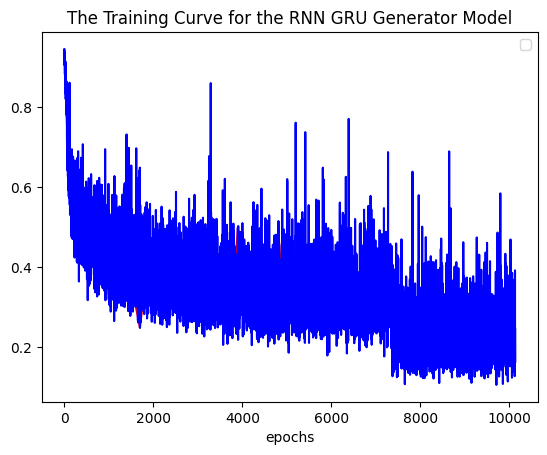

In [ ]:
plt.plot(loss,color = "g")
plt.title("The Training Curve for the RNN GRU Generator Model")
plt.xlabel("epochs")
plt.legend()
plt.show()

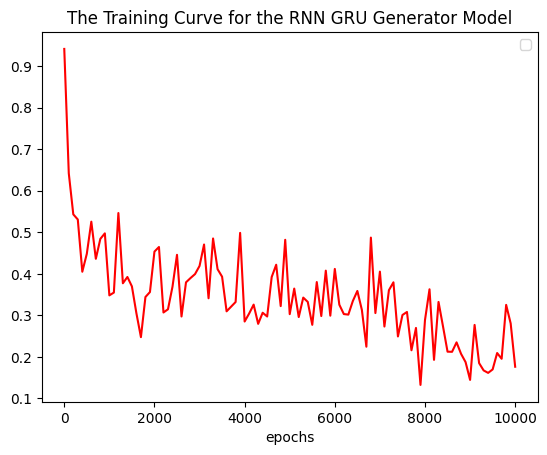

In [ ]:
indices = [100*i for i in range(int(len(loss)/100))]
plt.plot(indices,[loss[i] for i in indices],color="r")
plt.title("The Training Curve for the RNN GRU Generator Model")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
import pickle
file = open('drive/MyDrive/RL_model.pkl','wb')
pickle.dump(model,file)


file = open('drive/MyDrive/RL_data_losses.pkl','wb')
pickle.dump(loss,file)

# **Predictor Model and Dataset**

The model used in the Paper is a RNN sa well but the dataset used to train the Predictor is not available. Another Dataset is available that contains almost 2000 datapoints.

Since the dataset is quite slim we will go ahead and use the Linear Regression to predict the pIC-50 score of each molecule.

In [ ]:
class LR(torch.nn.Module):
    def __init__(self, input, hidden ,output):
        super(LR, self).__init__()
        self.linear = torch.nn.Linear(input, hidden)
        self.linear2 = torch.nn.Linear(hidden,output)


    def forward(self, x):
        out = self.linear(x)
        out = self.linear2(out)
        return out

In [ ]:
def one_hot_encode(mol):
  array = _to_array(mol)
  one_hot = np.zeros(len(tokens))
  one_hot[array] = 1
  return one_hot

In [ ]:
import pandas as pd

df = pd.read_csv("drive/MyDrive/jak2_data.csv")
df =df.iloc[np.random.permutation(len(df))]
df


,SMILES,pIC50
1628,N#CC1CC(O)CCC1n1cc(C(N)=O)c(Nc2ccc(S(=O)(=O)C(...,8.52
14,O=C(CN1CCN(c2ccccc2)CC1)Nc1cccc(-c2cnc3ccccc3n...,4.75
534,COc1ccc(-c2cccc3nc(Nc4ccnc(C)c4)nn23)cc1,6.76
457,CC(C)NC(=O)c1c[nH]c2ncc(Oc3ccccc3)nc12,6.60
1680,N#CCC(=O)N1CC(F)(F)C12CCN(c1[nH]cnc3nccc1-3)C2,8.77
...,...,...
749,N#CC1CC(O)CCC1n1cc(C(N)=O)c(Nc2ccc(OC(F)F)cc2)n1,7.12
377,O=c1[nH]c2cnc(-n3cnc4ccc(Cl)cc43)nc2n1C1CCOCC1,6.41
240,Cn1ccc(-c2cn(-c3ccccc3Cl)c(=O)c3c(N)[nH]nc23)n1,6.04
1759,CC(C)NS(=O)(=O)c1ccc(Nc2nn(C3CCCCC3C#N)cc2C(N)...,9.00


In [ ]:
X = [list(one_hot_encode(mol)) for mol in (list(df["SMILES"]))]
X = torch.tensor(X)
X = X.float()

Y = torch.tensor(list(df["pIC50"]))

<ipython-input-13-0c05a47f3f09>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)


In [ ]:
Predictor = LR(45,20,1)
perc_split = 0.9
split = int(perc_split*len(X))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

K = 2000
alpha = 0.0001
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Predictor.parameters(), lr=alpha)

Loss = []
Valid_Loss = []
for epoch in tqdm(range(K)):
  optimizer.zero_grad()
  Y_pred = Predictor(X_train)
  # get loss for the predicted output
  loss = criterion(Y_pred, Y_train.view((-1,1)))
  loss.backward()
  optimizer.step()
  Loss.append(loss.item())
  if epoch % 10 == 0:
    print(loss.item()/2)

  with torch.no_grad():
    Y_pred_test = Predictor(X_test)
    Valid_Loss.append(criterion(Y_pred_test,Y_test.view((-1,1))))




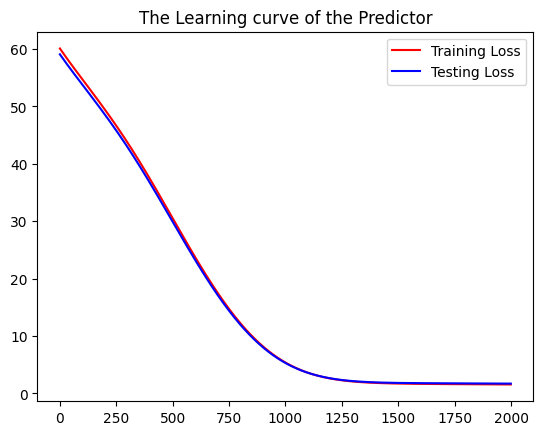

In [ ]:
plt.plot(Loss[:2000],color = 'r', label = "Training Loss")
plt.plot(Valid_Loss[:2000], color = 'b', label = 'Testing Loss')
plt.title("The Learning curve of the Predictor")
plt.legend()
plt.show()



#**Combining Generator and Predictor**

In [ ]:
Generator = model
Generator

GRU_RNN(
  (encoder): Embedding(45, 50)
  (stack_controls_layer): Linear(in_features=50, out_features=3, bias=True)
  (stack_input_layer): Linear(in_features=50, out_features=500, bias=True)
  (rnn): GRU(550, 50)
  (decoder): Linear(in_features=50, out_features=45, bias=True)
  (log_softmax): LogSoftmax(dim=1)
  (criterion): CrossEntropyLoss()
)

Visualize some of the created Molecules. Examples 1 and 2 are valid smiles representation. However, example 3 doesnot exist.

<ipython-input-13-0c05a47f3f09>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)


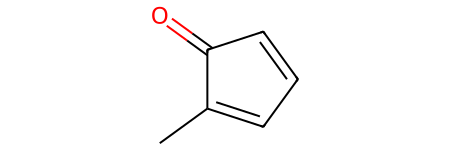

In [ ]:
Chem.MolFromSmiles(create(model,dt_set,100)[1:-1])

<ipython-input-13-0c05a47f3f09>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)


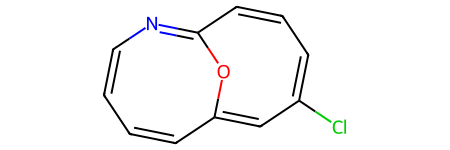

In [ ]:
Chem.MolFromSmiles(create(model,dt_set,40)[1:-1])

In [ ]:
Chem.MolFromSmiles(create(model,dt_set,40)[1:-1])

<ipython-input-13-0c05a47f3f09>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
[21:25:48] SMILES Parse Error: syntax error while parsing: Cr1C(N)-c1c(CC=C(=O)c1cccc(O)cc1)CCCC1
[21:25:48] SMILES Parse Error: Failed parsing SMILES 'Cr1C(N)-c1c(CC=C(=O)c1cccc(O)cc1)CCCC1' for input: 'Cr1C(N)-c1c(CC=C(=O)c1cccc(O)cc1)CCCC1'


In [ ]:
def verify_smiles(smiles):
  l = []
  for sm in smiles :
    mol = Chem.MolFromSmiles(sm,sanitize = True)
    if mol != None:
      l.append(mol)
  return l

In [ ]:
smiles = [create(model,dt_set,40)[1:-1] for _ in tqdm(range(1000))]
len(verify_smiles(smiles))/len(smiles)

In [ ]:
Generator = model
n_of_mol = 10000

smiles = [create(model,dt_set,100)[1:-1] for _ in tqdm(range(n_of_mol))]
sanitized = verify_smiles(smiles)[:-1]
sanitized = [Chem.MolToSmiles(sm) for sm in sanitized]
unique_smiles = list(np.unique(sanitized))[1:]

X = [list(one_hot_encode(mol)) for mol in unique_smiles]
X = torch.tensor(X)
X = X.float()

prediction = Predictor(X)


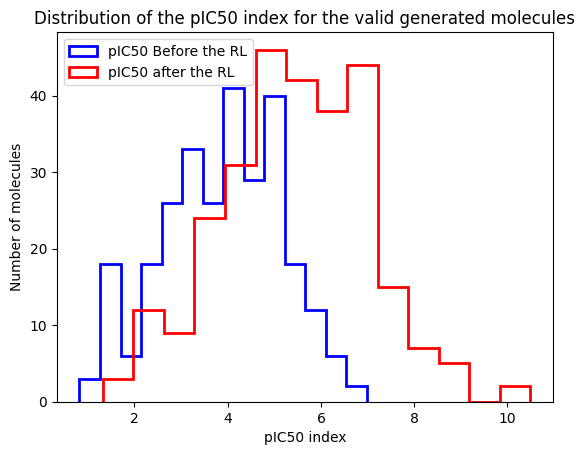

In [ ]:
p =prediction.detach().numpy()
plt.hist(p,bins = 14, edgecolor='b', linewidth=2.0, histtype='step',label = "pIC50 Before the RL")
plt.hist(k,bins = 14, edgecolor='r', linewidth=2.0, histtype='step',label = "pIC50 after the RL")
plt.title("Distribution of the pIC50 index for the valid generated molecules")
plt.xlabel('pIC50 index')
plt.ylabel("Number of molecules")
plt.legend()

#**Reinforcement Learning with Actor Critic**

In [ ]:

class RL_Gen_Pred(object):
  def __init__(self,generator,predictor,gamma):
    super(RL_Gen_Pred,self).__init__()
    self.generator = generator
    self.predictor = predictor
    self.gamma = gamma


  def iterate(self,iterate):
    loss = 0.0
    reward =0
    self.generator.optimizer.zero_grad()

    for k in (range(iterate)):
      r = 0
      while r == 0:
        new_mol = create(self.generator,dt_set,40)
        sanitized = verify_smiles([new_mol[1:-1]])
        if len(sanitized) == 0:

          r = 0
        else :
            X = one_hot_encode(new_mol)
            X = torch.tensor(X)
            X = X.float()

            prediction = self.predictor(X).detach().numpy()[0]
            r = np.exp(prediction/3)

      new_mol = _to_array(new_mol)
      reward += r


      #Getting the loss of new_mol creation from the generator
      hidden = Variable(torch.zeros(1, 1,self.generator.hidden_size))
      stack = Variable(torch.zeros(1, self.generator.stack_depth, self.generator.stack_width))

      for atom in range(len(new_mol)-1):
        output, hidden, stack = self.generator.forward(new_mol[atom], hidden,stack)
        log_probs = F.log_softmax(output,dim=1)
        next_one = new_mol[atom+1]
        log_probs = log_probs.reshape((len(tokens)))
        prob = log_probs[next_one]
        d = prob
        loss = loss - (prob*r)

        r = r * self.gamma

    loss = loss/iterate

    reward = reward/iterate


    #Updating Generator according to the new loss
    loss.backward()
    self.generator.optimizer.step()

    return reward, loss.item()








In [ ]:
RL = RL_Gen_Pred(model,Predictor,0.9)

In [ ]:
runs = 1
n_iter = 1000

L = []
R = []
for i in tqdm(range(n_iter)):
  r,l = RL.iterate(10)
  L.append(l)
  R.append(r)




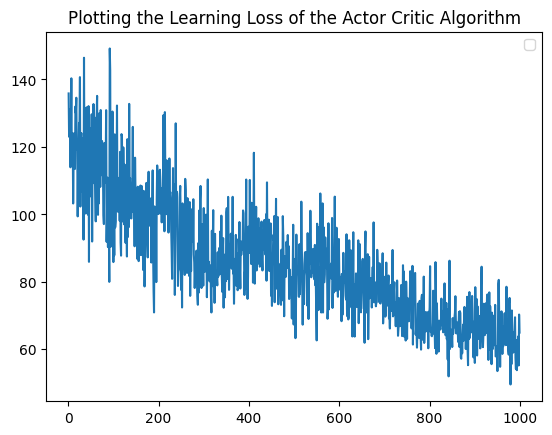

In [ ]:
plt.plot(L)
plt.title("Plotting the Learning Loss of the RL Algorithm")
plt.legend()

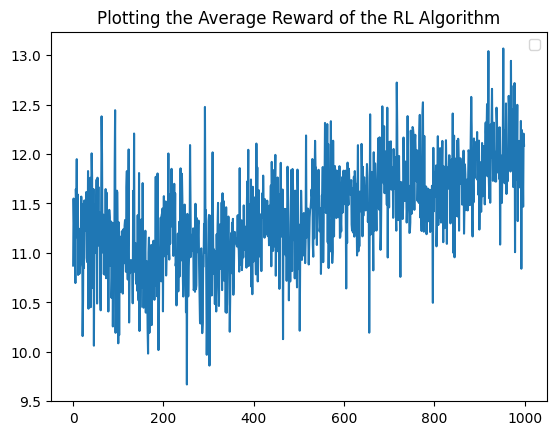

In [ ]:
plt.plot(R)
plt.title("Plotting the Average Reward of the RL Algorithm")
plt.legend()

(array([ 3.,  7., 14., 17., 23., 34., 49., 34., 40., 37., 11.,  2.,  5.,
         0.,  2.]),
 array([ 1.32109486,  1.93251197,  2.54392908,  3.15534619,  3.76676329,
         4.3781804 ,  4.98959751,  5.60101462,  6.21243172,  6.82384883,
         7.43526594,  8.04668305,  8.65810016,  9.26951726,  9.88093437,
        10.49235148]),
 <BarContainer object of 15 artists>)

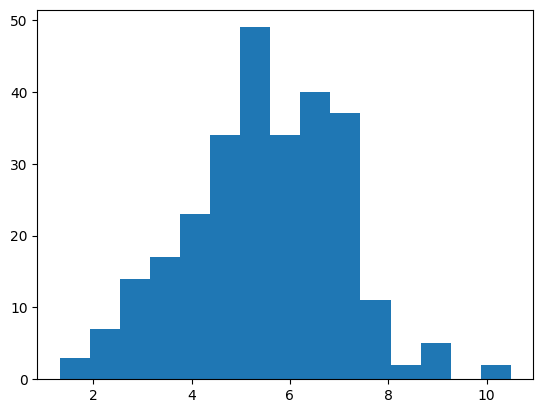

In [ ]:
Generator = model
n_of_mol = 10000

smiles = [create(model,dt_set,100)[1:-1] for _ in tqdm(range(n_of_mol))]
sanitized = verify_smiles(smiles)[:-1]
sanitized = [Chem.MolToSmiles(sm) for sm in sanitized]
unique_smiles = list(np.unique(sanitized))[1:]

X = [list(one_hot_encode(mol)) for mol in unique_smiles]
X = torch.tensor(X)
X = X.float()

k = Predictor(X).detach().numpy()

plt.plot(k)